In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import bz2
import pickle
from pandas.core.frame import DataFrame
import gensim
from gensim.models import CoherenceModel
from tqdm import tqdm
import time
import spacy
import logging
import warnings
warnings.filterwarnings('ignore')
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [3]:
from src.wikipreprocess import WikiPreprocess
from src.lda import LDA

In [4]:
path = 'datapicklesoup.bz2'
with bz2.BZ2File(os.path.join("../data",path), 'rb') as f:
    data = pickle.load(f)
data, _ = data
data = data[0:1000]
# print(data)
print(f"corpus size: {len(data)}")
wiki_pp = WikiPreprocess()
print("preprocessing data...")
preprocessed_data =  [wiki_pp.preprocess_document(text=d, min_token_len=4) for d in tqdm(data)]
print("creating bigrams...")
data_words_bigrams = wiki_pp.make_bigrams(preprocessed_data)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
print("lemmatizing data and creating dictionary from bigrams... ")
data_lemmatized = [wiki_pp.lemmatize(d, nlp, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']) for d in tqdm(data_words_bigrams)]
id2word_lemmatized = wiki_pp.create_dictionary(data_lemmatized)
print(id2word_lemmatized)
print("creating bag of words frequencies...")
corpus_lemmatized_bow = [id2word_lemmatized.doc2bow(text) for text in tqdm(data_lemmatized)]

1000
preprocessing data...


100%|██████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 681.83it/s]


creating bigrams...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4869.90it/s]


lemmatizing data and creating dictionary from bigrams... 


100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.03it/s]


Dictionary(19061 unique tokens: ['cuencellus', 'describe', 'find', 'forewing', 'margin']...)
creating bag of words frequencies...


100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10610.75it/s]


In [5]:
lda = LDA(corpus=corpus_lemmatized_bow, num_topics=10, vocab_len=len(id2word_lemmatized), alpha=0.01, beta=0.01)
lda.fit(documents=corpus_lemmatized_bow,burnin=10,max_iter=1)

  9%|████████▎                                                                                   | 1/11 [00:03<00:30,  3.04s/it]

iteration: 0 log_likelihood: -1056537.9042968613 perplexity: 1.1820599772273618e+24


100%|███████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:33<00:00,  3.05s/it]

iteration: 10 log_likelihood: -941614.959099031 perplexity: 2.845659475684493e+21


In [6]:
lda.print_topics(id2word_lemmatized, topn=10)

0 {'name': 0.004551610050691633, 'also': 0.004075334147235933, 'early': 0.003969495057579112, 'main': 0.003969495057579112, 'take': 0.0038636559679222898, 'late': 0.0037578168782654675, 'large': 0.0037048973334370566, 'group': 0.0037048973334370566, 'know': 0.0035461386989518234, 'long': 0.0034932191541234125}


1 {'second': 0.004752408839338433, 'time': 0.004643170617540055, 'first': 0.003933122175850598, 'include': 0.00382388395405222, 'year': 0.0036600266213546533, 'take': 0.003605407510455464, 'accord': 0.0035507883995562753, 'title': 0.0035507883995562753, 'use': 0.003386931066858708, 'also': 0.003386931066858708}


2 {'early': 0.004086393557591508, 'well': 0.0036386309434190377, 'begin': 0.0035826606166474793, 'even': 0.003470719963104361, 'mean': 0.003470719963104361, 'give': 0.003134898002475008, 'later': 0.0030789276757034493, 'case': 0.002966987022160332, 'much': 0.0028550463686172144, 'find': 0.0028550463686172144}


3 {'show': 0.005548731865987591, 'make': 0.004899481248756

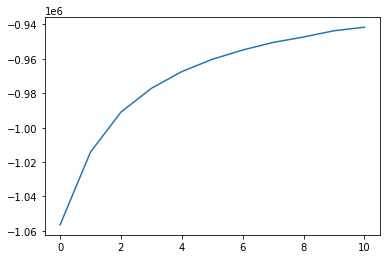

In [7]:
lda.plot_log_likelihood()

In [8]:
def plot_ldavis(self, dictionary):
    doc_lengths = [len(doc) for doc in self.corpus]
    tf = [dictionary.cfs[i] for i in range(len(dictionary))]
    data = {'topic_term_dists': self.get_phi(), 
        'doc_topic_dists': self.get_theta(),
        'doc_lengths': doc_lengths,
        'vocab': dictionary,
        'term_frequency': tf}
    vis_data = pyLDAvis.prepare(**data)
    return pyLDAvis.display(vis_data)

In [9]:
pyLDAvis.enable_notebook()
lda.plot_ldavis(id2word_lemmatized)